In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
_RANDOM_SEED = 2017

In [3]:
data = pd.read_csv('./data_with_features.csv')

## Apply one-hot encoding on the binned variables

In [4]:
data = pd.get_dummies(data, prefix='zip4', columns=['SitusZip_4digits'])
data = pd.get_dummies(data, prefix='zip3', columns=['SitusZip_3digits'])
data = pd.get_dummies(data, prefix='zip2', columns=['SitusZip_2digits'])
data = pd.get_dummies(data, prefix='square_footage_bin', columns=['SquareFootage_binned'])
data = pd.get_dummies(data, prefix='year_built_bin', columns=['YearBuilt_binned'])
data = pd.get_dummies(data, prefix='var_x_bin', columns=['var_x_binned'])

## Split into Train and Holdout

In [5]:
train, validate = model_selection.train_test_split(data, 
                                               test_size=0.2, 
                                               train_size=0.8, 
                                               stratify=data['y'], 
                                               random_state=_RANDOM_SEED)

In [6]:
train = train.reset_index(drop=True)
validate = validate.reset_index(drop=True)

In [7]:
zip4_cols = [x for x in data.columns if 'zip4_' in x]
zip3_cols = [x for x in data.columns if 'zip3_' in x]
zip2_cols = [x for x in data.columns if 'zip2_' in x]
sqft_cols = [x for x in data.columns if 'square_footage_bin_' in x]
year_built_cols = [x for x in data.columns if 'year_built_bin_' in x]
var_x_cols = [x for x in data.columns if 'var_x_bin_' in x]
categorical_features = (zip4_cols + zip3_cols + zip2_cols + 
                        sqft_cols + year_built_cols + var_x_cols + 
                        ['vacant'] + ['has_tax_exemption'])
numeric_features = ['Bathrooms_capped', 'NumberOfStories', 'estimated_minus_market_capped', 
                    'LotSize_capped', 'MarketImprovementPercent_parabola', 
                    'EstimatedValue_capped', 'TaxAmount_capped', 'MarketValue_capped', 
                    'MarketLandValue', 'MarketImprovementValue_capped']

## Apply Feature Scaling

In [8]:
scaled_features = []
for feat in (numeric_features):
    scaler = StandardScaler()
    scaled_feature = feat + '_scaled' 
    train[scaled_feature] = scaler.fit_transform(train[feat].values.reshape(-1, 1))
    validate[scaled_feature] = scaler.transform(validate[feat].values.reshape(-1, 1))
    scaled_features.append(scaled_feature)

/home/joel/Installs/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Split Train into k-folds

In [9]:
kfolds = model_selection.StratifiedKFold(n_splits=5, random_state=_RANDOM_SEED)
kfolds.get_n_splits(X=train, y=data['y'])

5

## Initial Pass at a Model with All Features 

In [11]:
def fit_model(train_data, test_data, features, response='y'):
    model = LogisticRegression(penalty='l2', 
                               random_state=_RANDOM_SEED, 
                               C=1.0,
                               class_weight='balanced', 
                               verbose=0)
    model = model.fit(X=train[features], y=train[response])
    test_data['pred_'] = model.predict_proba(X=test_data[features])[:, 1]
    train_data['pred_'] = model.predict_proba(X=train_data[features])[:, 1]
    test_auc = roc_auc_score(y_true=test_data['y'], y_score=test_data['pred_'])
    train_auc = roc_auc_score(y_true=train_data['y'], y_score=train_data['pred_'])
    return test_auc, train_auc

In [12]:
def fit_cv_models(kfolds, train, features, response='y'):
    test_aucs = []
    train_aucs = []
    for train_indexes, test_indexes in kfolds.split(X=train, y=train[response]):
        test_auc, train_auc = fit_model(train.ix[train_indexes], 
                                        train.ix[test_indexes], features=features)
        print('test_auc: {}\t train_auc: {}'.format(test_auc, train_auc))
        test_aucs.append(test_auc)
        train_aucs.append(train_auc)
    return np.mean(test_aucs), np.mean(train_aucs)

In [13]:
fit_cv_models(kfolds, train, features=scaled_features + categorical_features)

test_auc: 0.5716386090358876	 train_auc: 0.5702356017890658
test_auc: 0.5696109714364033	 train_auc: 0.5707383282212507
test_auc: 0.5672763655490909	 train_auc: 0.5713480235505348
test_auc: 0.5732434897446085	 train_auc: 0.5697781923834986
test_auc: 0.5709076422277736	 train_auc: 0.5703980761856408


(0.57053541559875276, 0.5704996444259981)

## Feature Selection

In [14]:
log_reg = LogisticRegression(penalty='l2', 
                             random_state=_RANDOM_SEED, 
                             C=1.0,
                             class_weight='balanced', 
                             verbose=0)
rfecv = RFECV(estimator=log_reg, step=1, cv=kfolds,
              scoring='roc_auc', n_jobs=6, verbose=0)
rfecv.fit(train[scaled_features + categorical_features], train['y'])

RFECV(cv=StratifiedKFold(n_splits=5, random_state=2017, shuffle=False),
   estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2017,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=6, scoring='roc_auc', step=1, verbose=0)

In [15]:
rfecv.n_features_, rfecv.support_, rfecv.ranking_

(59, array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True,  True], dtype=bool), array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,
         1,  1,  1,  1,  1,  7,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1, 11,  1,  8,  6,  1,  1,  1,  1,  1,  1,
         9,  1,  1,  1,  1,  1,  1,  5,  2,  1, 10,  1,  1,  1,  1,  1,  1,
         1]))

In [16]:
selected_features = []
deselected_features = []
for feat, support in zip(scaled_features + categorical_features, rfecv.support_):
    if not support:
        deselected_features.append(feat)
    else:
        selected_features.append(feat)

In [17]:
selected_features

['Bathrooms_capped_scaled',
 'NumberOfStories_scaled',
 'estimated_minus_market_capped_scaled',
 'LotSize_capped_scaled',
 'MarketImprovementPercent_parabola_scaled',
 'EstimatedValue_capped_scaled',
 'TaxAmount_capped_scaled',
 'MarketValue_capped_scaled',
 'MarketLandValue_scaled',
 'MarketImprovementValue_capped_scaled',
 'zip4_7657',
 'zip4_7861',
 'zip4_7862',
 'zip4_7863',
 'zip4_7864',
 'zip4_7865',
 'zip4_7870',
 'zip4_7871',
 'zip4_7872',
 'zip4_7873',
 'zip4_7874',
 'zip3_765',
 'zip3_786',
 'zip3_787',
 'zip2_76',
 'square_footage_bin_1',
 'square_footage_bin_2',
 'square_footage_bin_3',
 'square_footage_bin_4',
 'square_footage_bin_5',
 'square_footage_bin_6',
 'square_footage_bin_7',
 'square_footage_bin_8',
 'square_footage_bin_9',
 'square_footage_bin_10',
 'square_footage_bin_11',
 'square_footage_bin_12',
 'square_footage_bin_13',
 'square_footage_bin_15',
 'square_footage_bin_18',
 'square_footage_bin_19',
 'square_footage_bin_20',
 'square_footage_bin_21',
 'year_bui

In [18]:
deselected_features

['zip4_7866',
 'zip4_7875',
 'zip2_78',
 'square_footage_bin_14',
 'square_footage_bin_16',
 'square_footage_bin_17',
 'year_built_bin_3',
 'var_x_bin_3',
 'var_x_bin_4',
 'var_x_bin_6']

In [19]:
rfecv.grid_scores_

array([ 0.50373864,  0.50516036,  0.50732399,  0.50783902,  0.50893529,
        0.51054495,  0.51823625,  0.53093586,  0.53545223,  0.54393474,
        0.54664867,  0.54382099,  0.54330159,  0.54133587,  0.53993905,
        0.53876616,  0.53824823,  0.54103345,  0.54117008,  0.54208336,
        0.54217281,  0.54030513,  0.54237743,  0.5401489 ,  0.54059583,
        0.54027725,  0.54084955,  0.54074204,  0.53996759,  0.53973375,
        0.54005208,  0.54010404,  0.54025693,  0.54080907,  0.54065684,
        0.54181731,  0.54370975,  0.54317935,  0.54304174,  0.54292327,
        0.54284815,  0.54272757,  0.54278735,  0.54382526,  0.54414368,
        0.5449776 ,  0.54533474,  0.54523826,  0.54520566,  0.5458244 ,
        0.54590256,  0.54586306,  0.54609994,  0.5461096 ,  0.54649369,
        0.54744782,  0.54763524,  0.54767389,  0.5478738 ,  0.54773738,
        0.54766059,  0.54773206,  0.54777419,  0.54773891,  0.54769866,
        0.54771079,  0.54772285,  0.54768624,  0.54768671])

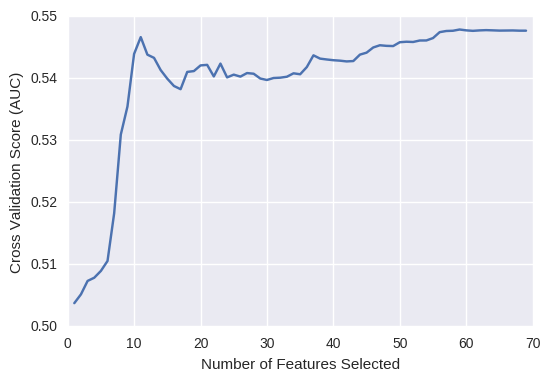

In [20]:
plt.figure()
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score (AUC)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Build Final Model on Entire Train Set with Selected Features

In [21]:
model = LogisticRegression(penalty='l2', 
                           random_state=_RANDOM_SEED, 
                           C=1.0,
                           class_weight='balanced', 
                           verbose=0)
model = model.fit(X=train[selected_features], y=train['y'])

In [22]:
validate['pred_1'] = model.predict_proba(X=validate[selected_features])[:, 1]
train['pred_1'] = model.predict_proba(X=train[selected_features])[:, 1]

In [23]:
roc_auc_score(y_true=train['y'], y_score=train['pred_1'])

0.57037620163388958

In [24]:
roc_auc_score(y_true=validate['y'], y_score=validate['pred_1'])

0.54487622978814143

In [25]:
fpr, tpr, thresholds = roc_curve(y_true=validate['y'],
                                 y_score=validate['pred_1'])
fpr_train, tpr_train, thresholds_train = roc_curve(y_true=train['y'],
                                                   y_score=train['pred_1'])

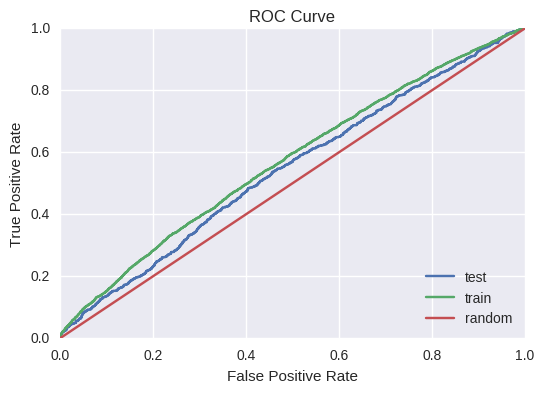

In [28]:
plt.figure()
plt.plot(fpr, tpr, label='test')
plt.plot(fpr_train, tpr_train, label='train')
x = np.arange(0, 1.01, 0.01)
plt.plot(x, x, label='random')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')